# Evaluation

## Introduction

In this notebook, we will evaluate the tokennizers and the trained models. 

## Load necessary files and objects

### Dependencies and basic functions

In [85]:
import os
import re
import copy
import json
import torch
from pathlib import Path
from transformers import AutoTokenizer, RobertaTokenizerFast, RobertaForMaskedLM, RobertaModel, BertModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaForTokenClassification
from transformers import pipeline, DataCollatorWithPadding, EarlyStoppingCallback, DataCollatorForTokenClassification
from collections import defaultdict
from tqdm import tqdm
import torch
import torch.nn.functional as F
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
import pandas as pd
import time
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from datasets import load_dataset, concatenate_datasets
import logging
from transformers import RobertaTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
import numpy as np
from datasets import load_metric
import morfessor




data_path = '/Users/jan/Documents/Master/Thesis/Code/Datasets'



def load_json(path):
    with open(path, 'r') as f:
        my_dict = json.load(f)
    return my_dict

def store_json(path, object):
    with open(path, 'w') as f:
        json.dump(object, f)

### Words ands texts

Here we load the SimLex words, a word list obtained from OnzeTaal, a word list obtained from the CELEX database, and the corpus the model has trained on in the form of word frequency dictionaries

#### SimLex

In [3]:
def load_simlex(simlex999, scores=False):
    # create list with a tuple for every word pair in the form of (word_1, word_2, similarity score, POS-tag)
    word_pairs = []

    # create a set with all words
    words_set = set([])

    with open(simlex999) as simlex:
        
        next(simlex) # skip first line
        
        for line in simlex:
    
            split = line.strip().split('\t')
            word_pairs.append(tuple(split))
            words_set.add(split[0])
            words_set.add(split[1])

    # create a list of unique words
    simlex_words = list(words_set)

    if scores:
        return word_pairs
    else:
        return simlex_words



simlex_path = os.path.join(data_path, 'SimLex-999', 'SimLex-999-Dutch-final.txt')
simlex_words = load_simlex(simlex_path)
simlex_pairs = load_simlex(simlex_path, scores=True)

In [159]:
len(simlex_words)

1045

#### OnzeTaal

In [5]:
word_path_onze_taal = '/Users/jan/Documents/Master/Thesis/Code/Datasets/Woordenlijsten/wordlist.txt'

# create set
words_onzetaal = set([])
with open(word_path_onze_taal) as wl:
    for line in wl:
        words_onzetaal.add(line.strip())

#### CELEX

In [7]:
# source 2 

celex = os.path.join(data_path, 'CELEX-2-NL', 'DUTCH', 'DML', 'DML.CD')
celex2 = os.path.join(data_path, 'CELEX-2-NL', 'DUTCH', 'DFW', 'DFW.CD')

def extract_celex_words(celex):
    
    out = set([])

    with open(celex) as cd:
        for line in cd:

            line = line.strip().split('\\')
            out.add(line[1])
    
    return out

# (we use two parts of celex)
words_celex1 = extract_celex_words(celex)
words_celex2 = extract_celex_words(celex2)

words_celex = words_celex1 | words_celex2

#### OSCAR

The models were trained on part of the Dutch version of the Oscar corpus. We load the corpus in the form of frequency dictionaries. The dictionaries are stored as json files, which we load here.

In [151]:
wf1 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_0.json')
wf2 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_1.json')
wf3 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_2.json')
wf4 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_3.json')
wf5 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_4.json')
wf7 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_6.json')
wf8 = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_7.json')


We want to combine these into one dictionary

In [152]:
def combine_word_frequencies(*dicts):
    combined_freq = defaultdict(int)
    for d in dicts:
        for word, count in d.items():
            combined_freq[word] += count
    return dict(combined_freq)

word_freqs_messy = combine_word_frequencies(wf1, wf2, wf3, wf4, wf5, wf7, wf8)

In [11]:
len(word_freqs_messy)

6915255

Let's store the combined dictionary

In [13]:
store_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/Word_freqs/word_freqs_all.json', word_freqs_messy)

And we want to clean the dictionary up a bit. This means removing punctuation marks, emoji's, etc.

In [153]:
def clean_word_frequencies(word_freq):
    pattern = re.compile(r'[^a-zA-Z\'\-]')
    cleaned_word_freq = {}
    
    for word, count in word_freq.items():
        if not pattern.search(word) and not any(char.isdigit() for char in word):
            cleaned_word_freq[word] = count
    
    return cleaned_word_freq

word_freqs = clean_word_frequencies(word_freqs_messy)

In [154]:
len(word_freqs)

5643591

In [156]:
def sum_words(word_freqs):
    print(f'The corpus had {sum(word_freqs.values())} words in total, of which {len(word_freqs)} unique words')

sum_words(word_freqs)

The corpus had 2113098722 words in total, of which 5643591 unique words


Let's store the cleaned dictionary

In [15]:
store_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/Word_freqs/word_freqs_all_clean.json', word_freqs)

In [8]:
word_freqs = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_all_clean.json')

### Tokenizers

Let's load the tokenizers

In [9]:

# tokenizers of existing models
tokenizer_bertje = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
tokenizer_robbert22 = RobertaTokenizerFast.from_pretrained("DTAI-KULeuven/robbert-2022-dutch-base")
tokenizer_robbert23 = RobertaTokenizerFast.from_pretrained("DTAI-KULeuven/robbert-2023-dutch-large")
tokenizer_robbertv2 = RobertaTokenizerFast.from_pretrained("pdelobelle/robbert-v2-dutch-base")

# WordPiece tokenizer
tokenizer_wp = AutoTokenizer.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Tokenizers/WP_snellius')

# BPE tokenizer
tokenizer_bpe = RobertaTokenizerFast.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Tokenizers/BPE_snellius')

Let's load our custom tokenizer

In [10]:

class CustomTokenizer:

    def __init__(self, segmentation_dictionary, wp_tokenizer, max_length=None, pad_to_multiple_of=None, model_max_length=None):



        self.wp_tokenizer = wp_tokenizer
        self.wp_vocab = self.wp_tokenizer.get_vocab()

        self.segmentations = {word: seg for word, seg in segmentation_dictionary.items() if len(seg) > 0}
        self.seg_dict = {}

        
        for word, segs in self.segmentations.items():
            out = []
            for i, seg in enumerate(segs):
                if i == 0:
                    out.append(seg)
                else:
                    out.append('##' + seg)
            self.seg_dict[word] = out
        

        self.segments = {seg for segs in self.seg_dict.values() for seg in segs}

        self.vocab = self.wp_vocab.copy()
        
      

        next_index = len(self.vocab)
        
        for element in self.segments:
            if element not in self.vocab:
                self.vocab[element] = next_index
                next_index += 1


        
        self.vocab_size = len(self.vocab)
        
        self.seg_dict_numbered = {}

        for word, segs in self.seg_dict.items():
            s = []
            for seg in segs:
                s.append(self.vocab[seg])
            self.seg_dict_numbered[word] = s
        
        
        self.inverted_vocab = {value: key for key, value in self.vocab.items()}
        self.max_length = max_length
        self.pad_to_multiple_of = pad_to_multiple_of
        self.padding_side = 'right'
        self.model_max_length = model_max_length

        ### special tokens

        special_tokens = ['[UNK]', '[MASK]', '[CLS]', '[SEP]', '[PAD]']
        special_token_ids = {}
        
        for token in special_tokens:
            if token not in self.vocab:
                self.vocab[token] = len(self.vocab)
            special_token_ids[token] = self.vocab[token]
        
        self.unk_token = '[UNK]'
        self.unk_token_id = special_token_ids['[UNK]']
        
        self.mask_token = '[MASK]'
        self.mask_token_id = special_token_ids['[MASK]']
    
        
        self.pad_token = '[PAD]'
        self.pad_token_id = special_token_ids['[PAD]']
        
        self.bos_token = '[CLS]'
        self.bos_token_id = special_token_ids['[CLS]']
        
        self.eos_token = '[SEP]'
        self.eos_token_id = special_token_ids['[SEP]']
        

        self.special_tokens = [self.vocab['[PAD]'], self.vocab['[UNK]'], self.vocab['[CLS]'], self.vocab['[SEP]'], self.vocab['[MASK]']]

        self.special_tokens_map = wp_tokenizer.special_tokens_map



    def __len__(self):
        return len(self.vocab)


    def check_tokens_in_dict(self, ids, tokens, dic_a):
     
        combined_tokens = []
        current_word = ''
        current_ids = []

        for i, token in enumerate(tokens):
            if token.startswith('##'):
                current_word += token[2:]
                current_ids.append(ids[i])
            else:
                if current_word:
                    combined_tokens.append((current_word, current_ids))
                current_word = token
                current_ids = [ids[i]]

        if current_word:
            combined_tokens.append((current_word, current_ids))
 
        result = []
        for word, ids_list in combined_tokens:
            if word in dic_a:
                result.extend(dic_a[word])  
            else:
                result.extend(ids_list)
        return result
    

    def check_tokens_in_dict_v2(self, ids, tokens, dic_a):

        combined_tokens = []
        current_word = ''
        current_tokens = []

        for i, token in enumerate(tokens):
            if token.startswith('##'):
                current_word += token[2:]
                current_tokens.append(token)
            else:
                if current_word:
                    combined_tokens.append((current_word, current_tokens))
        
                current_word = token
                current_tokens = [token]

        if current_word:
            combined_tokens.append((current_word, current_tokens))
    
        result = []
        for word, tokens_list in combined_tokens:
            if word in dic_a:
                result.extend(dic_a[word])  
            else:
                result.extend(tokens_list)

        return result



    def get_vocab(self):
        return self.vocab




    def _convert_token_to_id(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else:
            return self.unk_token_id

    
    def convert_tokens_to_ids(self, tokens):
        if isinstance(tokens, list):
            return [self._convert_token_to_id(token) for token in tokens]
        return self._convert_token_to_id(tokens)



    def _convert_id_to_token(self, id):
        return self.inverted_vocab[id]


    def convert_ids_to_tokens(self, ids):
        if isinstance(ids, list):
            return [self._convert_id_to_token(id) for id in ids]
        return self._convert_id_to_token(ids)


    def get_special_tokens_mask(self, token_ids, already_has_special_tokens=False):
        return [1 if self._is_special_token(token_id) else 0 for token_id in token_ids]


    def _is_special_token(self, token_id):

        if token_id in self.special_tokens:
            return True
        else:
            return False

    

    def pad(self, batch, return_tensors="pt", pad_to_multiple_of=None, padding=True, max_length=None):
        if pad_to_multiple_of is None:
            pad_to_multiple_of = self.pad_to_multiple_of

        input_ids_list = []
        for dictionary in batch:
            for key, value in dictionary.items():
                if key == "input_ids":
                    
                    if isinstance(value, torch.Tensor):
                        input_ids_list.append(value.tolist())
                    else:
                        input_ids_list.append(value)


        max_length = max(len(x) for x in input_ids_list)
        
        if pad_to_multiple_of is not None:
            max_length = (max_length + pad_to_multiple_of - 1) // pad_to_multiple_of * pad_to_multiple_of
        
        padded_batch = []
        for seq in input_ids_list:
            if len(seq) < max_length:
                seq.extend([self.pad_token_id] * (max_length - len(seq)))
            padded_batch.append(seq)
        
        attention_list = []
        for inner_list in padded_batch:
            p_list = [1 if value != self.pad_token_id else 0 for value in inner_list]
            attention_list.append(p_list)
        
        if return_tensors == "pt":
            return {'input_ids': torch.tensor(padded_batch, dtype=torch.long), 'attention_mask': torch.tensor(attention_list, dtype=torch.long)}
        
        return {'input_ids': padded_batch, 'attention_mask': attention_list}


    def tokenize(self, text):
        if isinstance(text, list):
            tokens_list = []
            for t in text:
                encoded = self.wp_tokenizer(t)
                tokens = encoded.tokens()
                tokens = self.check_tokens_in_dict_v2(encoded['input_ids'], tokens, self.seg_dict)[1:-1]
                tokens_list.append(tokens)
            return tokens_list
        else:
            encoded = self.wp_tokenizer(text)
            tokens = encoded.tokens()
            tokens = self.check_tokens_in_dict_v2(encoded['input_ids'], tokens, self.seg_dict)[1:-1]
            return tokens


    def encode(self, text, text_pair=None, add_special_tokens=True, return_tensors=None, max_length=None, pad_to_max_length=False, truncation=False):
        if text_pair:
            text = f"{text} {self.eos_token} {text_pair}"

        tokens = self.tokenize(text)
        
        if add_special_tokens:
            tokens = [self.bos_token] + tokens + [self.eos_token]
        
        if truncation and max_length and len(tokens) > max_length:
            tokens = tokens[:max_length]
        
        if pad_to_max_length and max_length and len(tokens) < max_length:
            tokens += [self.pad_token] * (max_length - len(tokens))
        
        input_ids = self.convert_tokens_to_ids(tokens)
        attention_mask = [1 if token != self.pad_token else 0 for token in tokens]

        if return_tensors == "pt":
            input_ids = torch.tensor([input_ids], dtype=torch.long)
            attention_mask = torch.tensor([attention_mask], dtype=torch.long)
        
        return {'input_ids': input_ids, 'attention_mask': attention_mask}

    def batch_encode_plus(self, texts, text_pairs=None, add_special_tokens=True, return_tensors=None, max_length=None, pad_to_max_length=False, truncation=False, pad_to_multiple_of=None):
        batch = []

        if text_pairs:
            for text, text_pair in zip(texts, text_pairs):
                batch.append(self.encode(
                    text, 
                    text_pair=text_pair, 
                    add_special_tokens=add_special_tokens, 
                    return_tensors=None, 
                    max_length=max_length, 
                    pad_to_max_length=pad_to_max_length, 
                    truncation=truncation
                ))
        else:
            for text in texts:
                batch.append(self.encode(
                    text, 
                    add_special_tokens=add_special_tokens, 
                    return_tensors=None, 
                    max_length=max_length, 
                    pad_to_max_length=pad_to_max_length, 
                    truncation=truncation
                ))

        padded_batch = self.pad(batch, return_tensors=return_tensors, pad_to_multiple_of=pad_to_multiple_of)

        return padded_batch


    def decode(self, ids, skip_special_tokens=False):
        out = ''
        for id in ids:
            token = self._convert_id_to_token(id)
            if skip_special_tokens and self._is_special_token(id):
                continue
            if token[:2] == '##':
                out += token[2:]
            else:
                out += ' ' + token
        
        
        out = re.sub(r'\s+([?.!,\'"])', r'\1', out)
        return out.strip()


    def __call__(self, text, text_pair=None, add_special_tokens=True, return_tensors=None, max_length=None, pad_to_max_length=False, truncation=False, pad_to_multiple_of=None):
        if isinstance(text, str):
      
            return self.encode(
                text, 
                text_pair=text_pair, 
                add_special_tokens=add_special_tokens, 
                return_tensors=return_tensors, 
                max_length=max_length, 
                pad_to_max_length=pad_to_max_length, 
                truncation=truncation
            )
        elif isinstance(text, list) and all(isinstance(t, str) for t in text):
      
            return self.batch_encode_plus(
                text, 
                text_pairs=text_pair, 
                add_special_tokens=add_special_tokens, 
                return_tensors=return_tensors, 
                max_length=max_length, 
                pad_to_max_length=pad_to_max_length, 
                truncation=truncation, 
                pad_to_multiple_of=pad_to_multiple_of
            )
        else:
            raise ValueError("Input text should be either a single string or a list of strings.")

    
    def __len__(self):
        return self.vocab_size

In [12]:
path_to_dict = '/Users/jan/Documents/Master/Thesis/Code/Tokenizers/segmentation_dictionary_final.json'
path_to_tokenizer = "/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_2815"

segmentation_dictionary = load_json(path_to_dict)
help_tokenizer = AutoTokenizer.from_pretrained(path_to_tokenizer)

tokenizer_morf = CustomTokenizer(segmentation_dictionary, help_tokenizer)

### Models

Let's first load the for masked language modelling, for which they were pretrained

In [15]:
model_morf = RobertaModel.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/MORF/x4/x4')
model_bpe = RobertaModel.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/BPE/x4/x4')
model_wp = RobertaModel.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/WP/x4/x4')

Some weights of RobertaModel were not initialized from the model checkpoint at /Users/jan/Documents/Master/Thesis/Code/Models/MORF/x4/x4 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /Users/jan/Documents/Master/Thesis/Code/Models/BPE/x4/x4 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /Users/jan/Documents/Master/Thesis/Code/Models/WP/x4/x4 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infere

In [14]:
model_robbertv2 = RobertaModel.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model_robbert22 = RobertaModel.from_pretrained("DTAI-KULeuven/robbert-2022-dutch-base")
model_robbert23 = RobertaModel.from_pretrained("DTAI-KULeuven/robbert-2023-dutch-large")
model_bertje = BertModel.from_pretrained("GroNLP/bert-base-dutch-cased")

Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbert-2022-dutch-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbert-2023-dutch-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [553]:
model_morf_masked = RobertaForMaskedLM.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/MORF/x4/x4')
model_bpe_masked = RobertaForMaskedLM.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/BPE/x4/x4')
model_wp_masked = RobertaForMaskedLM.from_pretrained('/Users/jan/Documents/Master/Thesis/Code/Models/WP/x4/x4')

Test

In [556]:
fill_mask_morf = pipeline(
    "fill-mask",
    model=model_morf_masked,
    tokenizer=tokenizer_morf
)

fill_mask_morf('[MASK] heb ik een vakantie geboekt')

[{'score': 0.26995694637298584,
  'token': 16825,
  'token_str': 'nu',
  'sequence': 'nu heb ik een vakantie geboekt'},
 {'score': 0.06926373392343521,
  'token': 21981,
  'token_str': 'hier',
  'sequence': 'hier heb ik een vakantie geboekt'},
 {'score': 0.05583801493048668,
  'token': 20181,
  'token_str': 'zo',
  'sequence': 'zo heb ik een vakantie geboekt'},
 {'score': 0.03687339276075363,
  'token': 19698,
  'token_str': 'zelf',
  'sequence': 'zelf heb ik een vakantie geboekt'},
 {'score': 0.030741985887289047,
  'token': 20075,
  'token_str': 'dan',
  'sequence': 'dan heb ik een vakantie geboekt'}]

In [97]:
fill_mask_bpe = pipeline(
    "fill-mask",
    model=model_bpe_masked,
    tokenizer=tokenizer_bpe
)

fill_mask_bpe('<mask> heb ik een vakantie geboekt')

[{'score': 0.14487196505069733,
  'token': 19429,
  'token_str': 'onlangs',
  'sequence': 'onlangs heb ik een vakantie geboekt'},
 {'score': 0.07995464652776718,
  'token': 3920,
  'token_str': 'nu',
  'sequence': 'nu heb ik een vakantie geboekt'},
 {'score': 0.04521726071834564,
  'token': 35483,
  'token_str': 'recent',
  'sequence': 'recent heb ik een vakantie geboekt'},
 {'score': 0.04469139873981476,
  'token': 3068,
  'token_str': 'hier',
  'sequence': 'hier heb ik een vakantie geboekt'},
 {'score': 0.043206147849559784,
  'token': 9055,
  'token_str': 'helaas',
  'sequence': 'helaas heb ik een vakantie geboekt'}]

In [96]:
fill_mask_wp = pipeline(
    "fill-mask",
    model=model_wp_masked,
    tokenizer=tokenizer_wp
)

fill_mask_wp('[MASK] heb ik een vakantie geboekt')

[{'score': 0.10433828830718994,
  'token': 17995,
  'token_str': 'vandaag',
  'sequence': 'vandaag heb ik een vakantie geboekt'},
 {'score': 0.10200200229883194,
  'token': 21862,
  'token_str': 'onlangs',
  'sequence': 'onlangs heb ik een vakantie geboekt'},
 {'score': 0.07347237318754196,
  'token': 22881,
  'token_str': 'recent',
  'sequence': 'recent heb ik een vakantie geboekt'},
 {'score': 0.06246524304151535,
  'token': 19073,
  'token_str': 'helaas',
  'sequence': 'helaas heb ik een vakantie geboekt'},
 {'score': 0.04347207024693489,
  'token': 17110,
  'token_str': 'zelf',
  'sequence': 'zelf heb ik een vakantie geboekt'}]

## Compare and evaluate the tokenizers

### Helper functions for comparisons and evaluation

#### Helper functions

In [19]:
def sort_dictionary(df, descending=True):

    if descending:
         sorted_dict = dict(sorted(df.items(), key=lambda item: item[1], reverse=True))
    else:
        sorted_dict = dict(sorted(df.items(), key=lambda item: item[1]))
    
    return sorted_dict

#### Functions for dictionaries and sets

In [20]:

def return_morphemes(df, form='list'):

    out = set([])
    for word, segs in df.items():
        for seg in segs:
            out.add(seg)
    
    if form == 'list':
        return list(out)
    else:
        return out



def compare_only_dictionaries(dict1, dict2, return_dict=False):

    diff = []
    not_in_2 = []
    not_in_1 = []
    
    for word, segs in dict1.items():
        if word in dict2:
            if not segs == dict2[word]:
                diff.append(word)
        else:
            not_in_2.append(word)
    
    for word, segs in dict2.items():
        if word in dict1:
            if not segs == dict1[word]:
                diff.append(word)
        else:
            not_in_1.append(word)

    dic = {word: (dict1[word], dict2[word]) for word in diff}

    if return_dict:
        return dic, not_in_2, not_in_1
    else:
        return diff, not_in_2, not_in_1


def return_words_not_in_dict(df, words):
    out = []
    for word in words:
        if word not in df:
            out.append(word)
    return out



def compare_dict_simlex(sim, dic, print_info=True):

    incl = []
    excl = []
    mult = 0

    for word in sim:
        if word in dic:
            incl.append(word)
            if len(dic[word]) > 1:
                mult += 1
        else:
            excl.append(word)

    p_in = 100 * len(incl) / len(sim)
    p_mult = 100 * mult / len(sim)
    
    if print_info:
        print(f'{round(p_in, 2)}% of words in simlex are in the dictionary')
        print(f'{round(p_mult, 2)}% of words in simlex are in the dictionary and have more than one segment')



def return_number_of_morphemes(dic):
    out = set([])
    for word, segs in dic.items():
        for seg in segs:
            out.add(seg)
    return len(out)


def count_morphemes_extra(df, print_info=True):

    total = set([])
    begin = set([])
    mid = set([])

    for word, segs in df.items():
        begin.add(segs[0])
        if len(segs) > 1:
           for item in segs[1:]:
               mid.add(item)
        for seg in segs:
            total.add(seg)

    not_at_begin = mid - begin

    size = len(total) + len(begin) - len(not_at_begin)

    if print_info:
    
        print(f'There are {len(total)} morphemes, out of these {len(begin)} appear at the begining of a word')
        print(f'{len(not_at_begin)} morphemes do not appear at the beginning. This means that the vocabulary has a size of {size} tokens (only lowercase).')
    
    else:
        return size


def in_corpus_or_not(word_freqs, words):

    words_in = {}
    words_out = []

    if isinstance(words, dict):
        words_in = {}
        words_out = {}
        for word, segs in words.items():
            if word in word_freqs:
                words_in[word] = word_freqs[word]            
            else:
                words_out[word] = segs
    else:
        words_in = {}
        words_out = []
        for word in words:
            if word in word_freqs:
                words_in[word] = word_freqs[word]            
            else:
                words_out.append(word)

    return words_in, words_out

def sort_by_number_of_segements(dic):

    n1 = {}
    n2 = {}
    n3 = {}
    n4plus = {}

    for word, segs in dic.items():
        if len(segs) == 1:
            n1[word] = segs
        elif len(segs) == 2:
            n2[word] = segs
        elif len(segs) == 3:
            n3[word] = segs
        else:
            n4plus[word] = segs
    
    return n1, n2, n3, n4plus



In [381]:
word_freqs = word_freqs
words_celex = words_celex
words_onzetaal = words_onzetaal
simlex_words = simlex_words
simlex_pairs = simlex_pairs
segmentation_dictionary = segmentation_dictionary

In [35]:
complex_words_2_plus = {word: segmentations for word, segmentations in segmentation_dictionary.items() if len(segmentations) >= 2}
complex_words_3_plus = {word: segmentations for word, segmentations in segmentation_dictionary.items() if len(segmentations) >= 3}
complex_words_4_plus = {word: segmentations for word, segmentations in segmentation_dictionary.items() if len(segmentations) >= 4}

In [36]:
seg_dict_in_corpus, seg_dict_not_in_corpus = in_corpus_or_not(word_freqs, segmentation_dictionary)

print('Number of words in segmentation dictionary seen during training:', len(seg_dict_in_corpus))
print('Number of words in the segmentation dictionary not seen during training:', len(seg_dict_not_in_corpus))

Number of words in segmentation dictionary seen during training: 503615
Number of words in the segmentation dictionary not seen during training: 38886


In [37]:
seg_dict_not_in_corpus_1, seg_dict_not_in_corpus_2, seg_dict_not_in_corpus_3, seg_dict_not_in_corpus_4_plus = sort_by_number_of_segements(seg_dict_not_in_corpus)

print('Number of words in the segmentation dictionary not seen during training:', len(seg_dict_not_in_corpus))
print('Of which with 1 segment:', len(seg_dict_not_in_corpus_1))
print('Of which with 2 segments:', len(seg_dict_not_in_corpus_2))
print('Of which with 3 segments:', len(seg_dict_not_in_corpus_3))
print('Of which with 4 or more segments:', len(seg_dict_not_in_corpus_4_plus))

Number of words in the segmentation dictionary not seen during training: 38886
Of which with 1 segment: 265
Of which with 2 segments: 12687
Of which with 3 segments: 17732
Of which with 4 or more segments: 8202


In [38]:
word_set = words_celex | words_onzetaal | set(simlex_words)

words_in_corpus, words_not_in_corpus = in_corpus_or_not(word_freqs, word_set)

print('Number of words in the word set seen during training:', len(words_in_corpus))
print('Number of words in the the word set not seen during training:', len(words_not_in_corpus))

Number of words in the word set seen during training: 351489
Number of words in the the word set not seen during training: 182546


#### Functions for tokenizers

In [21]:


def tokenizer_segmentations(words, tokenizer, only_splits=False):
    
    segs = {}

    for word in words:
        tokenization = tokenizer.tokenize(word)
        tokenization = [word.replace('Ġ', '') for word in tokenization]
        tokenization = [word.replace('##', '') for word in tokenization]
        segs[word] = tokenization
    
    if only_splits:
        return {word: seg for word, seg in segs.items() if len(seg) > 1}
    else:
        return segs


def compare_tokenizer_with_celex(df, tokenizer):

    words = [word for word in df]
    segs = tokenizer_segmentations(words, tokenizer)

    words_same = []
    words_diff = []
    diff = {}

    for word in df:
        if df[word] == segs[word]:
            words_same.append(word)
        else:
            words_diff.append(word)
    
    diff = {}
    for word in words_diff:
        if len(segs[word]) >= 2:
            c = {}
            c['CELEX'] = df[word]
            c['tokenizer'] = segs[word]
            diff[word] = c
    
    return words_same, words_diff, diff


def compare_tokenizer_segmentations(words, *tokenizers):

    results = {}

    for tokenizer in tokenizers:
        results[tokenizer] = tokenizer_segmentations(words, tokenizer)
    
    words_same = []
    words_diff = []

    for word in words:
        comp = {}
        for tokenizer in results:
            comp[tokenizer] = results[tokenizer][word]
        iterator = iter(comp.values())
        first_value = next(iterator)
        if all(value == first_value for value in iterator):
            words_same.append(word)
        else:
            words_diff.append(word)
    
    diff = {}
    for word in words_diff:
        c = {}
        for i, tokenizer in enumerate(tokenizers):
            c[i+1] = results[tokenizer][word]
        diff[word] = c

    
    if len(tokenizers) == 2:
        print(f'{len(words_same)} words out of the {len(words)} are tokenized in the same way by both tokenizers')
    else:
        print(f'{len(words_same)} words out of the {len(words)} are tokenized in the same way by all {len(tokenizers)} tokenizers')

    return words_same, words_diff, diff


def segmented_by_tokenizer(words, tokenizer):

    tokenizations = tokenizer_segmentations(words, tokenizer)

    split = {}
    no_split = []

    for word, tokenization in tokenizations.items():
        if len(tokenization) >= 2:
            split[word] = tokenization
        else:
            no_split.append(word)
    
    return no_split, split
    



In [40]:
training_words_not_split_bpe, training_words_split_bpe = segmented_by_tokenizer(words_in_corpus, tokenizer_bpe)
training_words_not_split_wp, training_words_split_wp = segmented_by_tokenizer(words_in_corpus, tokenizer_wp)
training_words_not_split_morf, training_words_split_morf = segmented_by_tokenizer(words_in_corpus, tokenizer_morf)

#### Functions to compare with text corpus

Here are some functions that relate to a text corpus. The text corpus must have the form of a dictionary with unique words as key and the number of occurences in the corpus as value.

In [22]:
# this function counts how many of the words in a dataframe occur at least once in the corpus, which is printed
# it returns two lists, one with the words in the corpus, one with the words not in the corpus
# update: now also returns frequencies
def dataset_in_corpus(df, word_freqs, lower=False, print_info=True):

    words_in = {}
    words_out = []

    if lower:

        word_freqs_lower = {key.lower(): value for key, value in word_freqs.items()}

        for word in df:
            if word in word_freqs or word in word_freqs_lower:
                if word in words_in:
                    if word in word_freqs:
                        words_in[word] += word_freqs[word]
                    else:
                        words_in[word] += word_freqs_lower[word]
                else:
                    if word in word_freqs:
                        words_in[word] = word_freqs[word]
                    else:
                        words_in[word] = word_freqs_lower[word]

            else:
                words_out.append(word)
    
    else:
    
        for word in df:
            if word in word_freqs:
                if word in words_in:
                    words_in[word] += word_freqs[word]
                else:
                    words_in[word] = word_freqs[word]
            
            else:
                words_out.append(word)

    
    n_in = len(words_in)
    n_out = len(words_out)
    
    if print_info:
        print(f'{round(100 * n_in / (n_in + n_out), 1)}% of words in the dataset are in the corpus')
        print(f'{round(100 * n_out / (n_in + n_out), 1)}% of words are not\n')

    return words_in, words_out



# this function calculates the number of words in the corpus that are in a dataframe. 
# two prints are made: one for every word in the corpus that is in the dataframe, one for every unique word in the corpus that is in the dataframe
# the function returns four dictionaries (in/not in dataframe - all/unique)
def corpus_in_dataset(df, word_freqs, lower=False, print_info=True):

    n_in = 0
    n_out = 0

    n_in_abs = 0
    n_out_abs = 0

    words_in = []
    words_out = []

    if lower:

        for word in word_freqs:
            if word in df or word.lower() in df:
                n_in += word_freqs[word]
                n_in_abs += 1
                words_in.append(word)
            else:
                n_out += word_freqs[word]
                n_out_abs += 1
                words_out.append(word)
    
    else:

        for word in word_freqs:
            if word in df:
                n_in += word_freqs[word]
                n_in_abs += 1
                words_in.append(word)
            else:
                n_out += word_freqs[word]
                n_out_abs += 1
                words_out.append(word)
    
    if print_info:
        print(f'{round(100 * n_in / (n_in + n_out), 1)}% of words in the corpus are in the dataset')
        print(f'{round(100 * n_out / (n_in + n_out), 1)}% of words are not\n')

        print(f'{round(100 * n_in_abs / (n_in_abs + n_out_abs), 1)}% of unique words in the corpus are in the dataset')
        print(f'{round(100 * n_out_abs / (n_in_abs + n_out_abs), 1)}% of unique words are not\n')

    return words_in, words_out, n_in, n_out, n_in_abs, n_out_abs




# this function uses the previous two functions to give a 'complete' picture of the relationship between a dataframe and the corpus
def compare_dataset_and_corpus(df, word_freqs, lower_=False, print_info_=True):

    n_corpus = sum(word_freqs.values())
    n_dataset = len(df)

    if print_info_:
        print(f'There are {n_corpus} words in the corpus')
        print(f'There are {n_dataset} words in the dataset\n')

    a, b, c, d, e, f = corpus_in_dataset(df, word_freqs, lower=lower_, print_info=print_info_)
    g, h = dataset_in_corpus(df, word_freqs, lower=lower_, print_info=print_info_)
    
    #return g, b, f
    return {'in both': g, 'not in dataset': b, 'not in corpus': h, 'n in both': c, 'n not in dataset': d, 'n in corpus': len(g), 'n not in corpus': len(h)}



#### Functions to evaluate whether tokenizers segment morphologically

In [106]:

def check_segmentation_correspondence(dict_a, dict_b):
    true_dict = {}
    false_dict = {}

    for word, segments_a in dict_a.items():
        if word in dict_b:
            segments_b = dict_b[word]
   
            segmentation_points_a = set()
            position = 0
            for segment in segments_a[:-1]:  
                position += len(segment)
                segmentation_points_a.add(position)
            
            segmentation_points_b = set()
            position = 0
            for segment in segments_b[:-1]:  
                position += len(segment)
                segmentation_points_b.add(position)

            if segmentation_points_a.issubset(segmentation_points_b):
                true_dict[word] = segments_a
            else:
                false_dict[word] = segments_a
        else:
            false_dict[word] = segments_a

    return true_dict, false_dict



def does_tokenizer_segment_morphologically(tokenizer, words, seg_dict):

    if tokenizer == tokenizer_bpe:
        tok = 'BPE'
    if tokenizer == tokenizer_wp:
        tok = 'WordPiece'
    if tokenizer == tokenizer_morf:
        tok = 'MORF'
    if tokenizer == tokenizer_bertje:
        tok = 'BERTje'
    if tokenizer == tokenizer_robbertv2:
        tok = 'RobBERT v2'
    if tokenizer == tokenizer_robbert22:
        tok = 'RobBERT 22'
    if tokenizer == tokenizer_robbert23:
        tok = 'RobBERT 23'
    


    print(f"Tokenizer: {tok}\n")

    segmentations = tokenizer_segmentations(words, tokenizer, only_splits=True)
    
    print(f'Number of words: {len(words)}')
    print(f'Number of words not split up: {len(words) - len(segmentations)}')
    print(f'Number of words split up: {len(segmentations)}')


    # in segmentation dictionary

    seg_in_dict = {}

    for word, segs in segmentations.items():
        if word in segmentation_dictionary:
            seg_in_dict[word] = segs
    
    print(f'Number of segmented words in segmentation dictionary: {len(seg_in_dict)}')

    # along morphologcal boundaries

    along_morph_boundaries, not_along_morph_boundaries = check_segmentation_correspondence(seg_in_dict, seg_dict)

    print(f'Number of words segmented along morphological boundaries: {len(along_morph_boundaries)}')
    print(f'Number of words not segmented along morphological boundaries: {len(not_along_morph_boundaries)}')


    # segmented equal to segmentation dictionary

    equal = {}

    for word, segs in seg_in_dict.items():
        if segs == segmentation_dictionary[word]:
            equal[word] = segs
    
    print(f'Number of words segmented identically to segmentation dictionary: {len(equal)}')



def return_does_tokenizer_segment_morphologically(tokenizer, words, seg_dict, return_dicts=False, return_numbers=False):


    segmentations = tokenizer_segmentations(words, tokenizer, only_splits=True)
    not_split = [word for word in words if not word in segmentations]

    # in segmentation dictionary



    seg_in_dict = {}
    

    for word, segs in segmentations.items():
        if word in segmentation_dictionary:
            seg_in_dict[word] = segs
    

    # along morphologcal boundaries

    along_morph_boundaries, not_along_morph_boundaries = check_segmentation_correspondence(seg_in_dict, seg_dict)


    # segmented equal to segmentation dictionary

    equal = {}

    for word, segs in seg_in_dict.items():
        if segs == segmentation_dictionary[word]:
            equal[word] = segs

    if return_numbers:
        return {len(not_split), len(along_morph_boundaries), len(not_along_morph_boundaries)}
    
    if return_dicts:
        return not_split, along_morph_boundaries, not_along_morph_boundaries
    
    return list(not_split), list(along_morph_boundaries), list(not_along_morph_boundaries)




def analyze_segments_and_splits(tokenizer, word_freqs):


    # Get the segmentations of all the words
    all_words = list(word_freqs.keys())
    segmentations = tokenizer_segmentations(all_words, tokenizer)

    total_segments = 0
    total_frequency = 0
    total_words = len(word_freqs)
    unweighted_segments_count = 0
    split_words_count = 0
    split_frequency_count = 0

    for word, freq in word_freqs.items():
        segments = segmentations[word]
        segment_count = len(segments)
        total_segments += segment_count * freq
        total_frequency += freq
        unweighted_segments_count += segment_count
        if segment_count > 1:
            split_words_count += 1
            split_frequency_count += freq

    if total_frequency == 0:
        weighted_average_segments = 0.0
    else:
        weighted_average_segments = total_segments / total_frequency
    
    if total_words == 0:
        unweighted_average_segments = 0.0
    else:
        unweighted_average_segments = unweighted_segments_count / total_words

    if total_words == 0:
        percentage_split_words = 0.0
    else:
        percentage_split_words = (split_words_count / total_words) * 100

    if total_frequency == 0:
        percentage_split_by_frequency = 0.0
    else:
        percentage_split_by_frequency = (split_frequency_count / total_frequency) * 100

    return (weighted_average_segments, 
            unweighted_average_segments, 
            percentage_split_by_frequency, 
            percentage_split_words)


def analyze_segments_and_splits_morfessor(model, word_freqs):


    # Get the segmentations of all the words
    all_words = list(word_freqs.keys())

    segmentations = {}
    for word in words_onzetaal:
         segmentations[word] = model.viterbi_segment(word)[0]

    total_segments = 0
    total_frequency = 0
    total_words = len(word_freqs)
    unweighted_segments_count = 0
    split_words_count = 0
    split_frequency_count = 0

    for word, freq in word_freqs.items():
        if word in word_freqs:
            segments = segmentations[word]
            segment_count = len(segments)
            total_segments += segment_count * freq
            total_frequency += freq
            unweighted_segments_count += segment_count
            if segment_count > 1:
                split_words_count += 1
                split_frequency_count += freq

    if total_frequency == 0:
        weighted_average_segments = 0.0
    else:
        weighted_average_segments = total_segments / total_frequency
    
    if total_words == 0:
        unweighted_average_segments = 0.0
    else:
        unweighted_average_segments = unweighted_segments_count / total_words

    if total_words == 0:
        percentage_split_words = 0.0
    else:
        percentage_split_words = (split_words_count / total_words) * 100

    if total_frequency == 0:
        percentage_split_by_frequency = 0.0
    else:
        percentage_split_by_frequency = (split_frequency_count / total_frequency) * 100

    return (weighted_average_segments, 
            unweighted_average_segments, 
            percentage_split_by_frequency, 
            percentage_split_words)
    
        

def filter_words_with_multiple_segments(word_freqs, segmentation_dictionary):

    filtered_word_freqs = {}

    for word, segments in segmentation_dictionary.items():
        if word in word_freqs and len(segments) > 1:
            filtered_word_freqs[word] = word_freqs[word]

    return filtered_word_freqs

def check_morph_correspondence(word, seg, dict_b):

    if word in dict_b:
        segments_b = dict_b[word]

        segmentation_points_a = set()
        position = 0
        for segment in seg[:-1]:  
            position += len(segment)
            segmentation_points_a.add(position)
        
        segmentation_points_b = set()
        position = 0
        for segment in segments_b[:-1]: 
            position += len(segment)
            segmentation_points_b.add(position)

        if segmentation_points_a.issubset(segmentation_points_b):
            return True
        else:
            return False
    else:
        return False



def does_tok_split_morph(tokenizer, word_freqs, segmentation_dictionary):

    segmentations = tokenizer_segmentations(word_freqs.keys(), tokenizer, only_splits=True)

    total_n_words = 0
    n_morph = 0
    n_equal = 0

    for word, segs in segmentations.items():
        freq = word_freqs[word]
        total_n_words += freq
        
        if word in segmentation_dictionary:
            if check_morph_correspondence(word, segs, segmentation_dictionary):
                n_morph += freq
            
            if segs == segmentation_dictionary[word]:
                n_equal += freq

    percentage_morph = (n_morph / total_n_words) * 100
    percentage_equal = (n_equal / total_n_words) * 100

    return percentage_morph, percentage_equal





def does_tok_split_morph_absolute(tokenizer, word_freqs, segmentation_dictionary):

    segmentations = tokenizer_segmentations(word_freqs.keys(), tokenizer, only_splits=True)

    total_n_words = 0
    n_morph = 0
    n_equal = 0

    for word, segs in segmentations.items():
        
        total_n_words += 1
        
        if word in segmentation_dictionary:
            if check_morph_correspondence(word, segs, segmentation_dictionary):
                n_morph += 1
            
            if segs == segmentation_dictionary[word]:
                n_equal += 1

    percentage_morph = (n_morph / total_n_words) * 100
    percentage_equal = (n_equal / total_n_words) * 100


    return percentage_morph, percentage_equal





def does_tok_split_morph_morfessor(model, word_freqs, segmentation_dictionary):

    segmentations = {}
    for word in words_onzetaal:
         segmentations[word] = model.viterbi_segment(word)[0]
    
    segmentations = {word: segs for word, segs in segmentations.items() if len(segs) > 1}

    total_n_words = 0
    n_morph = 0
    n_equal = 0

    for word, segs in segmentations.items():
        if word in word_freqs:
            freq = word_freqs[word]
            total_n_words += freq
            
            if word in segmentation_dictionary:
                if check_morph_correspondence(word, segs, segmentation_dictionary):
                    n_morph += freq
                
                if segs == segmentation_dictionary[word]:
                    n_equal += freq

    percentage_morph = (n_morph / total_n_words) * 100
    percentage_equal = (n_equal / total_n_words) * 100

    return percentage_morph, percentage_equal



def does_tok_split_morph_absolute_morfessor(model, word_freqs, segmentation_dictionary):

    segmentations = {}
    for word in words_onzetaal:
         segmentations[word] = model.viterbi_segment(word)[0]
    
    segmentations = {word: segs for word, segs in segmentations.items() if len(segs) > 1}

    total_n_words = 0
    n_morph = 0
    n_equal = 0

    for word, segs in segmentations.items():
        if word in word_freqs:
        
            total_n_words += 1
            
            if word in segmentation_dictionary:
                if check_morph_correspondence(word, segs, segmentation_dictionary):
                    n_morph += 1
                
                if segs == segmentation_dictionary[word]:
                    n_equal += 1

    percentage_morph = (n_morph / total_n_words) * 100
    percentage_equal = (n_equal / total_n_words) * 100


    return percentage_morph, percentage_equal

### Comparison with corpus

In [581]:
def sort_dict_by_frequency(word_freq_dict, rev=True):
    return dict(sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=rev))


word_freqs_desc = sort_dict_by_frequency(word_freqs)
word_freqs_asc = sort_dict_by_frequency(word_freqs, rev=False)

In [582]:
from itertools import islice

def get_first_n_elements(dictionary, n):

    return dict(islice(dictionary.items(), n))

word_freqs_asc_1000 = get_first_n_elements(word_freqs_asc, 1000)
word_freqs_desc_1000 = get_first_n_elements(word_freqs_desc, 1000)



#### Number of tokens split up (and avg length)

In [596]:
split_info_wp = analyze_segments_and_splits(tokenizer_wp, word_freqs)


In [597]:
split_info_bpe = analyze_segments_and_splits(tokenizer_bpe, word_freqs)

In [598]:
split_info_morf = analyze_segments_and_splits(tokenizer_morf, word_freqs)

In [599]:
print('WP:', split_info_wp)
print('BPE:', split_info_bpe)
print('MORF:', split_info_morf)

WP: (1.1219943234625647, 3.1001931217198413, 8.738465083412226, 99.56455030139499)
BPE: (1.2552270021201593, 3.210728594612898, 19.47103037432058, 99.7607020069314)
MORF: (1.4044444644740077, 3.827883877481554, 28.217846889597425, 99.65667249806019)


#### Split up along morphological boundaries (corpus)

In [99]:
seg_dict_in_corpus, seg_dict_not_in_corpus = in_corpus_or_not(word_freqs, segmentation_dictionary)

In [604]:
split_morph_morf = does_tok_split_morph(tokenizer_bpe, seg_dict_in_corpus, segmentation_dictionary)

In [662]:
split_morph_bpe = does_tok_split_morph(tokenizer_bpe, seg_dict_in_corpus, segmentation_dictionary)

1780617170
1637634111
1304651468


In [663]:
split_morph_wp = does_tok_split_morph(tokenizer_wp, seg_dict_in_corpus, segmentation_dictionary)

1780617170
1738947415
1272028696


In [664]:
split_morph_bpe

(91.97002806616764, 73.26962190306185)

In [665]:
split_morph_wp

(97.65981392844819, 71.4375171390715)

In [668]:
split_morph_bpe_abs = does_tok_split_morph_absolute(tokenizer_bpe, seg_dict_in_corpus, segmentation_dictionary)

503615
265336
142720


In [669]:
split_morph_wp_abs = does_tok_split_morph_absolute(tokenizer_wp, seg_dict_in_corpus, segmentation_dictionary)

503615
274156
5547


In [670]:
split_morph_bpe_abs

(52.686278208552174, 28.339108247371502)

In [671]:
split_morph_wp_abs

(54.43761603605929, 1.1014366132859426)

### Comparison with simlex

In [411]:
does_tokenizer_segment_morphologically(tokenizer_bpe, simlex_words, segmentation_dictionary)

Tokenizer: BPE

Number of words: 1045
Number of words not split up: 604
Number of words split up: 441
Number of segmented words in segmentation dictionary: 374
Number of words segmented along morphological boundaries: 94
Number of words not segmented along morphological boundaries: 280
Number of words segmented identically to segmentation dictionary: 57


In [413]:
does_tokenizer_segment_morphologically(tokenizer_wp, simlex_words, segmentation_dictionary)

Tokenizer: WodPiece

Number of words: 1045
Number of words not split up: 884
Number of words split up: 161
Number of segmented words in segmentation dictionary: 122
Number of words segmented along morphological boundaries: 50
Number of words not segmented along morphological boundaries: 72
Number of words segmented identically to segmentation dictionary: 33


In [420]:
does_tokenizer_segment_morphologically(tokenizer_morf, simlex_words, segmentation_dictionary)

Tokenizer: MORF

Number of words: 1045
Number of words not split up: 691
Number of words split up: 354
Number of segmented words in segmentation dictionary: 309
Number of words segmented along morphological boundaries: 308
Number of words not segmented along morphological boundaries: 1
Number of words segmented identically to segmentation dictionary: 308


In [415]:
does_tokenizer_segment_morphologically(tokenizer_bertje, simlex_words, segmentation_dictionary)

Tokenizer: BERTje

Number of words: 1045
Number of words not split up: 906
Number of words split up: 139
Number of segmented words in segmentation dictionary: 106
Number of words segmented along morphological boundaries: 58
Number of words not segmented along morphological boundaries: 48
Number of words segmented identically to segmentation dictionary: 38


In [45]:
does_tokenizer_segment_morphologically(tokenizer_robbertv2, simlex_words, segmentation_dictionary)

Tokenizer: RobBERT v2

Number of words: 1045
Number of words not split up: 489
Number of words split up: 556
Number of segmented words in segmentation dictionary: 487
Number of words segmented along morphological boundaries: 106
Number of words not segmented along morphological boundaries: 381
Number of words segmented identically to segmentation dictionary: 63


In [46]:
does_tokenizer_segment_morphologically(tokenizer_robbert22, simlex_words, segmentation_dictionary)

Tokenizer: RobBERT 22

Number of words: 1045
Number of words not split up: 492
Number of words split up: 553
Number of segmented words in segmentation dictionary: 484
Number of words segmented along morphological boundaries: 104
Number of words not segmented along morphological boundaries: 380
Number of words segmented identically to segmentation dictionary: 62


In [47]:
does_tokenizer_segment_morphologically(tokenizer_robbert23, simlex_words, segmentation_dictionary)

Tokenizer: RobBERT 23

Number of words: 1045
Number of words not split up: 906
Number of words split up: 139
Number of segmented words in segmentation dictionary: 104
Number of words segmented along morphological boundaries: 38
Number of words not segmented along morphological boundaries: 66
Number of words segmented identically to segmentation dictionary: 25


In [48]:
len(tokenizer_robbert23)

50000

In [49]:
len(tokenizer_robbertv2)

40000

In [50]:
len(tokenizer_robbert22)

42774

In [28]:
bpe_not_split, bpe_split_morph, bpe_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_bpe, simlex_words, segmentation_dictionary)
wp_not_split, wp_split_morph, wp_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_wp, simlex_words, segmentation_dictionary)
morf_not_split, morf_split_morph, morf_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_morf, simlex_words, segmentation_dictionary)

In [54]:
rob1_not_split, rob1_split_morph, rob1_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_robbertv2, simlex_words, segmentation_dictionary)
rob22_not_split, rob22_split_morph, rob22_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_robbert22, simlex_words, segmentation_dictionary)
rob23_not_split, rob23_split_morph, rob23_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_robbert23, simlex_words, segmentation_dictionary)

bertje_not_split, bertje_split_morph, bertje_split_not_moprh = return_does_tokenizer_segment_morphologically(tokenizer_bertje, simlex_words, segmentation_dictionary)

In [29]:
bpe_words = [bpe_not_split, bpe_split_morph, bpe_split_not_moprh]
wp_words = [wp_not_split, wp_split_morph, wp_split_not_moprh]
morf_words = [morf_not_split, morf_split_morph, morf_split_not_moprh]

In [55]:
rob1_words = [rob1_not_split, rob1_split_morph, rob1_split_not_moprh]
rob22_words = [rob22_not_split, rob22_split_morph, rob22_split_not_moprh]
rob23_words = [rob23_not_split, rob23_split_morph, rob23_split_not_moprh]

bertje_words = [bertje_not_split, bertje_split_morph,bertje_split_not_moprh]

In [30]:
def categorize_tuples(word_lists, tuples_list):

    if not (isinstance(word_lists, list) and len(word_lists) == 3 and all(isinstance(sublist, list) for sublist in word_lists)):
        raise ValueError("word_lists should be a list of three lists")
    if not all(isinstance(t, tuple) and len(t) == 4 for t in tuples_list):
        raise ValueError("tuples_list should be a list of tuples with four elements each")
    
    first_list = set(word_lists[0])
    second_list = set(word_lists[1])
    third_list = set(word_lists[2])

    list1_tuples = []
    list2_tuples = []
    list3_tuples = []

    for t in tuples_list:
        word1, word2 = t[0], t[1]

        if word1 in first_list and word2 in first_list:
            list1_tuples.append(t)
        if (word1 in first_list and word2 in first_list) or (word1 in second_list and word2 in second_list):
            list2_tuples.append(t)
        if word1 in second_list and word2 in second_list:
            list2_tuples.append(t)
        if word1 in third_list and word2 in third_list:
            list3_tuples.append(t)

    return list1_tuples, list2_tuples, list3_tuples



In [31]:
bpe_pairs_no_split, bpe_pairs_morpf, bpe_pairs_no_morph = categorize_tuples(bpe_words, simlex_pairs)
wp_pairs_no_split, wp_pairs_morpf, wp_pairs_no_morph = categorize_tuples(wp_words, simlex_pairs)
morf_pairs_no_split, morf_pairs_morpf, morf_pairs_no_morph = categorize_tuples(morf_words, simlex_pairs)

In [56]:
rob1_pairs_no_split, rob1_pairs_morpf, rob1_pairs_no_morph = categorize_tuples(rob1_words, simlex_pairs)
rob22_pairs_no_split, rob22_pairs_morpf, rob22_pairs_no_morph = categorize_tuples(rob22_words, simlex_pairs)
rob23_pairs_no_split, rob23_pairs_morpf, rob23_pairs_no_morph = categorize_tuples(rob23_words, simlex_pairs)

bertje_pairs_no_split, bertje_pairs_morpf, bertje_pairs_no_morph = categorize_tuples(bertje_words, simlex_pairs)

In [32]:
bpe_pairs = [bpe_pairs_no_split, bpe_pairs_morpf, bpe_pairs_no_morph]
wp_pairs = [wp_pairs_no_split, wp_pairs_morpf, wp_pairs_no_morph]
morf_pairs = [morf_pairs_no_split, morf_pairs_morpf, morf_pairs_no_morph]



In [58]:
len(rob1_pairs_no_split)

318

In [60]:
len(rob22_pairs_no_split)

321

In [62]:
999 - 318

681

In [61]:
len(rob23_pairs_no_split)

815

In [63]:
999 - 815

184

In [36]:
len(bpe_pairs_no_split)

439

In [37]:
999 - 439

560

In [38]:
len(wp_not_split)

884

In [39]:
999 - 884

115

### Morfessor

In [87]:
model_file = "model_nl_complete.bin"
io = morfessor.MorfessorIO()
model_nl = io.read_binary_model_file(model_file)

word = 'huisarrest'
# for segmenting new words we use the viterbi_segment(compound) method
print(model_nl.viterbi_segment(word)[0])

['huis', 'arrest']


In [89]:
morfessor_dictionary = {}
for word in words_onzetaal:
    morfessor_dictionary[word] = model_nl.viterbi_segment(word)[0]

In [91]:
morfessor_morphemes = set([])
for segs in morfessor_dictionary.values():
    for seg in segs:
        morfessor_morphemes.add(seg)
    
len(morfessor_morphemes)

70643

In [93]:
def count_morphemes_extra(df, print_info=True):

    total = set([])
    begin = set([])
    mid = set([])

    for word, segs in df.items():
        if len(segs) > 0:
            begin.add(segs[0])
        if len(segs) > 1:
           for item in segs[1:]:
               mid.add(item)
        for seg in segs:
            total.add(seg)

    not_at_begin = mid - begin

    size = len(total) + len(begin) - len(not_at_begin)

    if print_info:
    
        print(f'There are {len(total)} morphemes, out of these {len(begin)} appear at the beginning of a word')
        print(f'{len(not_at_begin)} morphemes do not appear at the beginning. This means that the vocabulary has a size of {size} tokens (only lowercase).')
    
    else:
        return size

count_morphemes_extra(morfessor_dictionary)

There are 70643 morphemes, out of these 67880 appear at the beginning of a word
2763 morphemes do not appear at the beginning. This means that the vocabulary has a size of 135760 tokens (only lowercase).


In [102]:
does_tok_split_morph_morfessor(model_nl, seg_dict_in_corpus, segmentation_dictionary)

(60.70909431531084, 43.08585919503626)

In [103]:
does_tok_split_morph_absolute_morfessor(model_nl, seg_dict_in_corpus, segmentation_dictionary)

(94.33425260850822, 51.787392945991286)

## Model evaluation 1: Perplexity

Simple

In [393]:
def calculate_perplexity(model, tokenizer, text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt')
    
    # Get input IDs and attention mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
    
    # Get the loss (cross-entropy)
    loss = outputs.loss
    
    # Calculate perplexity
    perplexity = torch.exp(loss)
    
    return perplexity.item()

In [558]:
#text = 'dit is een simpele nederlandse zin, waarin we kijken hoe goed het model een woord voorspelt'
text = 'het lijkt erop dat een langere zin voor een lagere score zorgt. klopt dat ook? misschien is dat omdat het meer context geeft.'

In [559]:
calculate_perplexity(model_bpe_masked, tokenizer_bpe, text)

2.756091594696045

In [560]:
calculate_perplexity(model_wp_masked, tokenizer_wp, text)

3.4510180950164795

In [561]:
calculate_perplexity(model_morf_masked, tokenizer_morf, text)

11.022215843200684

## Model evaluation 2: SimLex

### Functions

In [111]:
def get_word_embedding(model, tokenizer, word, pooling_strategy='mean'):
    inputs = tokenizer(word, return_tensors='pt')
    input_ids = inputs['input_ids']


    if input_ids.shape[1] > 2:
        input_ids = input_ids[:, 1:-1]

    with torch.no_grad():
        embeddings = model.get_input_embeddings()(input_ids)

    token_vectors = embeddings.squeeze(0)

    if pooling_strategy == 'mean':
        word_embedding = token_vectors.mean(dim=0)
    elif pooling_strategy == 'max':
        word_embedding, _ = token_vectors.max(dim=0)
    elif pooling_strategy == 'sum':
        word_embedding = token_vectors.sum(dim=0)
    elif pooling_strategy == 'first':
        word_embedding = token_vectors[0]
    elif pooling_strategy == 'last':
        word_embedding = token_vectors[-1]
    else:
        raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")
    
    return word_embedding


def get_word_vector(model, tokenizer, word, layer=-1, pooling_strategy='mean'):
    inputs = tokenizer(word, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    

    if input_ids.shape[1] > 2: 
        input_ids = input_ids[:, 1:-1]
        attention_mask = attention_mask[:, 1:-1]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states[layer]
    token_vectors = hidden_states.squeeze(0)

    if pooling_strategy == 'mean':
        word_vector = token_vectors.mean(dim=0)
    elif pooling_strategy == 'max':
        word_vector, _ = token_vectors.max(dim=0)
    elif pooling_strategy == 'sum':
        word_vector = token_vectors.sum(dim=0)
    elif pooling_strategy == 'first':
        word_vector = token_vectors[0]
    elif pooling_strategy == 'last':
        word_vector = token_vectors[-1]
    else:
        raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")
    
    return word_vector


def cosine_similarity(vec1, vec2):
    
    return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()


def get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean'):

    similarities = []
    
    for word1, word2, score, word_type in word_pairs:
        if layer == 'embedding':
            vec1 = get_word_embedding(model, tokenizer, word1)
            vec2 = get_word_embedding(model, tokenizer, word2)
        else:
            vec1 = get_word_vector(model, tokenizer, word1, layer, pooling_strategy)
            vec2 = get_word_vector(model, tokenizer, word2, layer, pooling_strategy)
        similarity = cosine_similarity(vec1, vec2)
        similarities.append((word1, word2, float(score), similarity))
    
    return similarities



def filter_word_pairs(word_pairs_with_scores, list_A, list_B):

    both_in_A = []
    both_in_B = []
    one_in_A_one_in_B = []
    
    set_A = set(list_A)
    set_B = set(list_B)
    
    for word1, word2, score, similarity in word_pairs_with_scores:
        if word1 in set_A and word2 in set_A:
            both_in_A.append((word1, word2, score, similarity))
        elif word1 in set_B and word2 in set_B:
            both_in_B.append((word1, word2, score, similarity))
        elif (word1 in set_A and word2 in set_B) or (word1 in set_B and word2 in set_A):
            one_in_A_one_in_B.append((word1, word2, score, similarity))
    
    return both_in_A, both_in_B, one_in_A_one_in_B

    
def calculate_spearman_correlation(similarities):
    human_scores = [score for _, _, score, _ in similarities]
    cosine_similarities = [similarity for _, _, _, similarity in similarities]
    correlation, _ = spearmanr(human_scores, cosine_similarities)
    return correlation


def calculate_spearman_total(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean'):

    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    human_scores = [score for _, _, score, _ in similarities]
    cosine_similarities = [similarity for _, _, _, similarity in similarities]
    
    correlation, _ = spearmanr(human_scores, cosine_similarities)
    return correlation


def create_spearman_dataframe(models, tokenizers, word_pairs_groups, model_names, layer='embedding', pooling_strategy='mean'):
    results = []

    for model, tokenizer, word_pairs_group, model_name in zip(models, tokenizers, word_pairs_groups, model_names):
        spearman_values = []
        for word_pairs in word_pairs_group:
            spearman_value = calculate_spearman_total(model, tokenizer, word_pairs, layer=layer, pooling_strategy=pooling_strategy)
            spearman_values.append(spearman_value)
        
        # Ensure there are exactly 3 elements for A, B, and C
        if len(spearman_values) == 3:
            results.append({
                'Model Name': model_name,
                'No split': spearman_values[0],
                'Morphological split': spearman_values[1],
                'No morphological split': spearman_values[2]
            })
        else:
            raise ValueError("Each word_pairs_group should contain exactly 3 elements for columns A, B, and C")

    df = pd.DataFrame(results)
    return df


def compare_models_a(model_names, models, tokenizers, word_pairs, layer='embedding', pooling_strategy='mean'):
    results = []
    for name, model, tokenizer in zip(model_names, models, tokenizers):
        similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
        
        # Separate words into split and no_split categories
        words = set(word for word_pair in word_pairs for word in word_pair[:2])
        no_split, split = segmented_by_tokenizer(words, tokenizer)
        
        both_split = []
        both_no_split = []
        one_split_one_not = []
        
        for word1, word2, score, similarity in similarities:
            if word1 in split and word2 in split:
                both_split.append((word1, word2, score, similarity))
            elif word1 in no_split and word2 in no_split:
                both_no_split.append((word1, word2, score, similarity))
            else:
                one_split_one_not.append((word1, word2, score, similarity))
        
        spearman_both_split = calculate_spearman_correlation(both_split) if both_split else None
        spearman_both_no_split = calculate_spearman_correlation(both_no_split) if both_no_split else None
        spearman_one_split_one_not = calculate_spearman_correlation(one_split_one_not) if one_split_one_not else None
        spearman_all_pairs = calculate_spearman_correlation(similarities)
        
        results.append({
            'Model': name, 
            'Spearman Both Split': spearman_both_split,
            'Spearman Both No Split': spearman_both_no_split,
            'Spearman One Split One Not': spearman_one_split_one_not,
            'Spearman All Pairs': spearman_all_pairs
        })
    
    df = pd.DataFrame(results)
    return df




def compare_models_b(model_names, models, tokenizers, word_pairs, word_splits, layer='embedding', pooling_strategy='mean'):
    results = []
    
    for name, model, tokenizer, split_data in zip(model_names, models, tokenizers, word_splits):
        similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
        
        spearman_correlations = {}
        
        for category, word_pair_list in split_data.items():
            category_pairs = [(word1, word2, score, similarity) for word1, word2, score, similarity in similarities 
                              if (word1, word2) in word_pair_list or (word2, word1) in word_pair_list]
            spearman_correlations[f'Spearman {category}'] = calculate_spearman_correlation(category_pairs)
        
        spearman_all_pairs = calculate_spearman_correlation(similarities)
        
        spearman_correlations['Model'] = name
        spearman_correlations['Spearman All Pairs'] = spearman_all_pairs
        
        results.append(spearman_correlations)
    
    df = pd.DataFrame(results)
    return df




def get_sorted_similarities_for_word_pairs(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean', reverse=True):
    
    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    def sort_key(item):
        word1, word2, score, similarity = item
        score_normalized = (score - 1) / 9
        similarity_normalized = (similarity + 1) / 2
        absolute_difference = abs(similarity_normalized - score_normalized)
        
        return absolute_difference

    sorted_similarities = sorted(similarities, key=sort_key, reverse=reverse)
    
    sorted_similarities_with_diff = [
        (word1, word2, score, similarity, sort_key((word1, word2, score, similarity)))
        for word1, word2, score, similarity in sorted_similarities
    ]
    
    return sorted_similarities_with_diff



def print_similarities(model, tokenizer, word_pairs, top_k=10, layer='embedding', pooling_strategy='mean', reverse=True):

    similarities = get_sorted_similarities_for_word_pairs(model, tokenizer, word_pairs, layer=layer, pooling_strategy=pooling_strategy, reverse=reverse)

    if reverse == True:
        print('Worst matches between simlex and model:\n')
    if reverse == False:
        print('Best matches between simlex and model:\n')

    for pair in similarities[:top_k]:
        print(pair)


def get_sorted_similarities_for_word_pairs_df(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean', reverse=True, top_n=None):
    
    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    def sort_key(item):
        word1, word2, score, similarity = item
        score_normalized = (score - 1) / 9
        similarity_normalized = (similarity + 1) / 2
        absolute_difference = abs(similarity_normalized - score_normalized)
        return absolute_difference
    
    sorted_similarities = sorted(similarities, key=sort_key, reverse=reverse)
    
    extended_tuples = []
    
    for word1, word2, score, similarity in sorted_similarities:
        score_normalized = (score - 1) / 9
        similarity_normalized = (similarity + 1) / 2, 2
        absolute_difference = abs(similarity_normalized - score_normalized)
        score_normalized_10 = round(score_normalized * 10, 2)
        similarity_normalized_10 = round(similarity_normalized * 10, 2)
        absolute_difference_10 = absolute_difference * 10
        extended_tuples.append((word1, word2, score, similarity, score_normalized_10, similarity_normalized_10, absolute_difference_10))
    
    df = pd.DataFrame(extended_tuples, columns=['Word 1', 'Word 2', 'SimLex score', 'Cosine similarity', 'SimLex normalized', 'Cosine normalized', 'Absolute difference'])
    
    if top_n is not None:
        return df.head(top_n)
    else:
        return df




# def plot_similarities_scatterplot(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean'):
#     """
#     Plot a scatterplot of SimLex ratings vs. similarity scores for a given model.
    
#     Args:
#     - model: The model to use for generating word vectors.
#     - tokenizer: The tokenizer to use.
#     - word_pairs: List of tuples containing word pairs, their human similarity scores, and types.
#     - layer: The layer from which to extract the vectors (default: 'last' for the last layer, or 'embedding' for the embedding layer).
#     - pooling_strategy: The strategy for pooling token vectors ('mean', 'max', 'sum', 'first', 'last').
    
#     Returns:
#     - None
#     """
#     similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
#     human_scores = [float(score) for _, _, score, _ in similarities]
#     cosine_similarities = [float(similarity) for _, _, _, similarity in similarities]
    
#     plt.figure(figsize=(10, 6))
#     plt.scatter(human_scores, cosine_similarities, alpha=0.6, edgecolors='w', linewidth=0.5)
#     plt.title('SimLex Ratings vs. Similarity Scores')
#     plt.xlabel('SimLex Rating')
#     plt.ylabel('Cosine Similarity')
#     plt.grid(True)
#     plt.show()

def plot_similarities_scatterplot(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean'):

    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    human_scores = [float(score) for _, _, score, _ in similarities]
    cosine_similarities = [float(similarity) for _, _, _, similarity in similarities]
    
    # Convert lists to numpy arrays for linear regression
    X = np.array(human_scores).reshape(-1, 1)
    y = np.array(cosine_similarities)
    
    # Fit a linear regression model
    reg = LinearRegression().fit(X, y)
    trend_line = reg.predict(X)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(human_scores, cosine_similarities, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.plot(human_scores, trend_line, color='red', linewidth=2, label='Trend')
    plt.title('SimLex Ratings vs. Similarity Scores')
    plt.xlabel('SimLex Rating')
    plt.ylabel('Cosine Similarity')
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_similarities_scatterplot_save(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean', output_file='scatterplot.png'):
    """
    Plot a scatterplot of SimLex ratings vs. similarity scores for a given model and save it as an image file.
    
    Args:
    - model: The model to use for generating word vectors.
    - tokenizer: The tokenizer to use.
    - word_pairs: List of tuples containing word pairs, their human similarity scores, and types.
    - layer: The layer from which to extract the vectors (default: 'last' for the last layer, or 'embedding' for the embedding layer).
    - pooling_strategy: The strategy for pooling token vectors ('mean', 'max', 'sum', 'first', 'last').
    - output_file: The filename for the saved plot (default: 'scatterplot.png').
    
    Returns:
    - None
    """
    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    human_scores = [float(score) for _, _, score, _ in similarities]
    cosine_similarities = [float(similarity) for _, _, _, similarity in similarities]
    
    # Convert lists to numpy arrays for linear regression
    X = np.array(human_scores).reshape(-1, 1)
    y = np.array(cosine_similarities)
    
    # Fit a linear regression model
    reg = LinearRegression().fit(X, y)
    trend_line = reg.predict(X)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(human_scores, cosine_similarities, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.plot(human_scores, trend_line, color='red', linewidth=2, label='Trend')
    plt.title('SimLex Ratings vs. Similarity Scores')
    plt.xlabel('SimLex Rating')
    plt.ylabel('Cosine Similarity')
    plt.grid(True)
    plt.legend()
    
    # Save the plot as an image file
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()



def get_sorted_similarities_for_word_pairs_df(model, tokenizer, word_pairs, layer='embedding', pooling_strategy='mean', reverse=True, top_n=None, groups=2):
    
    similarities = get_similarities_for_word_pairs(model, tokenizer, word_pairs, layer, pooling_strategy)
    
    def sort_key(item):
        word1, word2, score, similarity = item
        score_normalized = (score - 1) / 9
        similarity_normalized = (similarity + 1) / 2
        absolute_difference = abs(similarity_normalized - score_normalized)
        return absolute_difference
    
    sorted_similarities = sorted(similarities, key=sort_key, reverse=reverse)
    
    extended_tuples = []
    
    for word1, word2, score, similarity in sorted_similarities:
        score_normalized = (score - 1) / 9
        similarity_normalized = (similarity + 1) / 2
        absolute_difference = abs(similarity_normalized - score_normalized)
        score_normalized_10 = score_normalized * 10
        score_normalized_10 = round(score_normalized * 10, 2)
        similarity_normalized_10 = round(similarity_normalized * 10, 2)
        absolute_difference_10 = absolute_difference * 10
        extended_tuples.append((word1, word2, score, similarity, score_normalized_10, similarity_normalized_10, absolute_difference_10))
    
    df = pd.DataFrame(extended_tuples, columns=['Word 1', 'Word 2', 'SimLex score', 'Cosine similarity', 'SimLex normalized', 'Cosine normalized', 'Absolute difference'])
    
    # Divide into groups
    if groups == 2:
        df['Group'] = pd.qcut(df['SimLex score'], q=2, labels=['Low', 'High'])
    elif groups == 3:
        df['Group'] = pd.qcut(df['SimLex score'], q=3, labels=['Low', 'Middle', 'High'])
    
    if top_n is not None:
        return df.head(top_n)
    else:
        return df


def get_min_cosine_normalized(df):
    min_cosine_normalized = df['Cosine normalized'].min()
    return min_cosine_normalized


### Comparisons

#### Spearman

In [17]:
calculate_spearman_total(model_wp, tokenizer_wp, simlex_pairs, layer='embedding', pooling_strategy='mean')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.3639273284986334

In [33]:
names = ['BPE', 'WP', 'MORF']
models = [model_bpe, model_wp, model_morf]
tokenizers = [tokenizer_bpe, tokenizer_wp, tokenizer_morf]
word_pair_groups = [bpe_pairs, wp_pairs, morf_pairs]

create_spearman_dataframe(models, tokenizers, word_pair_groups, names)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Model Name,No split,Morphological split,No morphological split
0,BPE,0.311621,0.288543,0.044624
1,WP,0.407329,0.408414,0.500000
2,MORF,-0.044620,-0.014258,NaN


In [52]:
names = ['BPE', 'WP', 'MORF', 'BERTje', 'RobBERT v2', 'RobBERT 22', 'RobBERT 23']
models = [model_bpe, model_wp, model_morf, model_bertje, model_robbertv2, model_robbert22, model_robbert23]
tokenizers = [tokenizer_bpe, tokenizer_wp, tokenizer_morf, tokenizer_bertje, tokenizer_robbertv2, tokenizer_robbert22, tokenizer_robbert23]

compare_models_a(names, models, tokenizers, simlex_pairs)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Model,Spearman Both Split,Spearman Both No Split,Spearman One Split One Not,Spearman All Pairs
0,BPE,0.242085,0.311621,0.141910,0.194628
1,WP,0.580279,0.407329,0.303843,0.363927
2,MORF,-0.005882,-0.044620,0.154075,0.022280
3,BERTje,0.438725,0.483388,0.336747,0.406424
4,RobBERT v2,0.198556,0.407215,0.177316,0.196875
5,RobBERT 22,0.206789,0.401648,0.170416,0.194182
6,RobBERT 23,0.041266,0.473195,0.337418,0.441597


In [108]:
names = ['BPE', 'WP', 'MORF', 'BERTje', 'RobBERT v2', 'RobBERT 22', 'RobBERT 23']
models = [model_bpe, model_wp, model_morf, model_bertje, model_robbertv2, model_robbert22, model_robbert23]
tokenizers = [tokenizer_bpe, tokenizer_wp, tokenizer_morf, tokenizer_bertje, tokenizer_robbertv2, tokenizer_robbert22, tokenizer_robbert23]

compare_models_a(names, models, tokenizers, simlex_pairs, layer=1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,Model,Spearman Both Split,Spearman Both No Split,Spearman One Split One Not,Spearman All Pairs
0,BPE,-0.008841,0.321070,-0.044461,-0.023529
1,WP,0.223025,0.341680,0.210002,0.191115
2,MORF,-0.067643,0.030683,0.013063,-0.018467
3,BERTje,0.610294,0.410066,0.260875,0.300526
4,robBERT,-0.115543,0.235053,0.060401,0.121643


#### BERTje

In [43]:
df = get_sorted_similarities_for_word_pairs_df(model_bertje, tokenizer_bertje, simlex_pairs, reverse=False)
df


,Word 1,Word 2,SimLex score,Cosine similarity,SimLex normalized,Cosine normalized,Absolute difference,Group
0,bereiken,volbrengen,6.14,0.143322,5.711111,5.716609,0.005498,High
1,strand,kust,7.20,0.379254,6.888889,6.896272,0.007383,High
2,argumenteren,bewijzen,6.23,0.165107,5.811111,5.825533,0.014422,High
3,bereiken,worden,5.70,0.039909,5.222222,5.199545,0.022677,High
4,agressie,vijandigheid,6.69,0.259877,6.322222,6.299383,0.022840,High
...,...,...,...,...,...,...,...,...
994,moeilijk,gemakkelijk,1.92,0.431242,1.022222,7.156210,6.133987,Low
995,noord,west,1.83,0.413574,0.922222,7.067871,6.145649,Low
996,maaltijd,staart,0.49,0.127152,-0.566667,5.635758,6.202425,Low
997,vinger,handpalm,1.15,0.277668,0.166667,6.388341,6.221674,Low


In [44]:
get_min_cosine_normalized(df)

3.9595580101013184

In [525]:
print_similarities(model_bertje, tokenizer_bertje, simlex_pairs, reverse=False)

Best matches between simlex and model:

('bereiken', 'volbrengen', 6.14, 0.14332172274589539, 0.0005497502618365679)
('strand', 'kust', 7.2, 0.3792543411254883, 0.0007382816738552567)
('argumenteren', 'bewijzen', 6.23, 0.1651066392660141, 0.0014422085218959158)
('bereiken', 'worden', 5.7, 0.03990896791219711, 0.0022677382661236978)
('agressie', 'vijandigheid', 6.69, 0.2598765194416046, 0.002283962501419934)
('blik', 'aluminium', 5.78, 0.048442963510751724, 0.006889629355735227)
('gelukkig', 'blij', 7.09, 0.33717864751815796, 0.008077342907587659)
('luisteren', 'gehoorzamen', 6.05, 0.1037612110376358, 0.009230505592293214)
('beslissen', 'kiezen', 6.91, 0.3318631947040558, 0.009264930685361161)
('wolk', 'mist', 6.5, 0.2029011994600296, 0.00966051138109636)


In [526]:
print_similarities(model_bertje, tokenizer_bertje, simlex_pairs, reverse=True)

Worst matches between simlex and model:

('badkamer', 'slaapkamer', 2.03, 0.5418561100959778, 0.6564836106035444)
('vinger', 'handpalm', 1.15, 0.27766817808151245, 0.6221674223740896)
('maaltijd', 'staart', 0.49, 0.12715166807174683, 0.6202425007025401)
('noord', 'west', 1.83, 0.4135742783546448, 0.6145649169551002)
('moeilijk', 'gemakkelijk', 1.92, 0.4312419295310974, 0.6133987425433265)
('tandarts', 'kolonel', 0.7, 0.1575966775417328, 0.6121316721041997)
('balk', 'kooi', 0.72, 0.1614702045917511, 0.6118462134069866)
('doos', 'hoed', 0.93, 0.2047705501317978, 0.6101630528436767)
('dak', 'vloer', 1.15, 0.25117334723472595, 0.6089200069506964)
('geven', 'weigeren', 0.9, 0.19321832060813904, 0.6077202714151806)


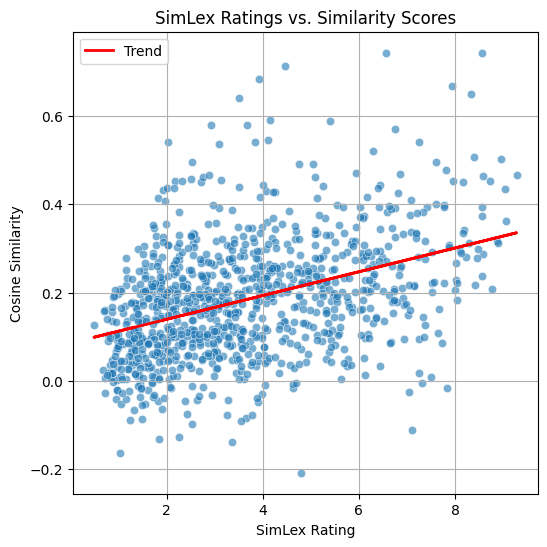

In [446]:
plot_similarities_scatterplot(model_bertje, tokenizer_bertje, simlex_pairs) #new

#### robBERT

In [387]:
print_similarities(model_robbert, tokenizer_robbert, simlex_pairs, reverse=False)

Best matches between simlex and model:

('rondzwerven', 'dwalen', 7.83, 0.5158247351646423)
('arts', 'dokter', 9.28, 0.8375405073165894)
('vlug', 'snel', 8.95, 0.7624897956848145)
('muziekgroep', 'orkest', 8.04, 0.5696713924407959)
('bedrijf', 'onderneming', 8.72, 0.7219323515892029)
('cruciaal', 'belangrijk', 8.59, 0.678463339805603)
('competentie', 'vermogen', 7.73, 0.47562283277511597)
('zelfverzekerd', 'zeker', 7.49, 0.4654563069343567)
('maken', 'opbouwen', 7.65, 0.4543026089668274)
('essentieel', 'noodzakelijk', 8.55, 0.6499861478805542)


In [388]:
print_similarities(model_robbert, tokenizer_robbert, simlex_pairs, reverse=True)

Worst matches between simlex and model:

('tandarts', 'kolonel', 0.7, 0.5383347272872925)
('noord', 'west', 1.83, 0.7810719013214111)
('water', 'zout', 0.87, 0.5566100478172302)
('boomstam', 'bad', 0.96, 0.573367178440094)
('volkslied', 'rietje', 0.87, 0.5489444732666016)
('kerel', 'meisje', 1.14, 0.5883347392082214)
('dak', 'vloer', 1.15, 0.5899280905723572)
('meisje', 'dienstmeisje', 1.93, 0.7558972239494324)
('binnentreden', 'verschuldigd zijn', 1.07, 0.5633722543716431)
('balk', 'kooi', 0.72, 0.48460230231285095)


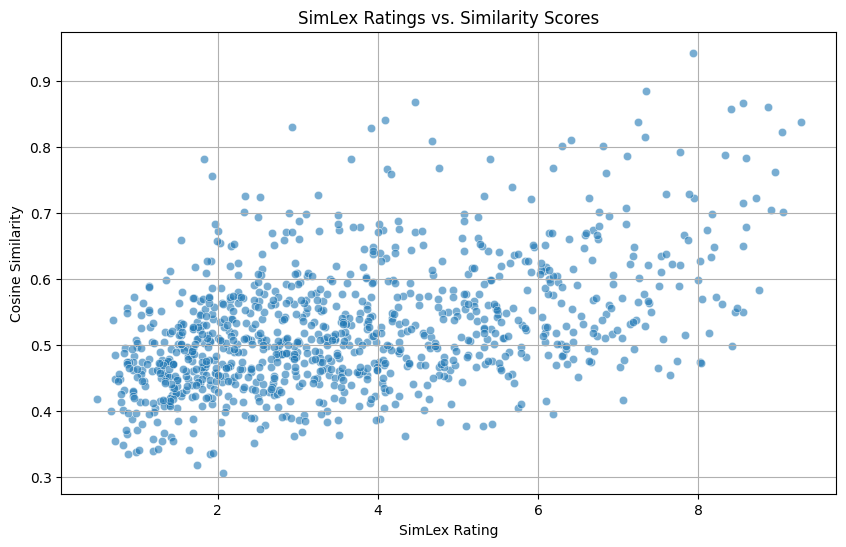

In [352]:
plot_similarities_scatterplot(model_robbert, tokenizer_robbert, simlex_pairs) # new

#### WP

In [508]:
get_sorted_similarities_for_word_pairs_df(model_wp, tokenizer_wp, simlex_pairs, reverse=False)

,Word 1,Word 2,SimLex score,Cosine similarity,SimLex normalized,Cosine normalized,Absolute difference,Group
0,delen,melden,6.10,0.128541,5.67,5.64,0.023961,High
1,gelukkigheid,geluk,6.60,0.237426,6.22,6.19,0.035095,High
2,leider,manager,7.14,0.356518,6.82,6.78,0.039632,High
3,beschermen,verdedigen,7.60,0.457194,7.33,7.29,0.047365,High
4,wolk,mist,6.50,0.232428,6.11,6.16,0.051028,High
...,...,...,...,...,...,...,...,...
994,biografie,fictie,1.00,0.280114,0.00,6.40,6.400571,Low
995,zuid,noord,2.93,0.709810,2.14,8.55,6.404607,Low
996,vertrekken,verschijnen,1.27,0.349760,0.30,6.75,6.448802,Low
997,onderkant,zijkant,2.15,0.568047,1.28,7.84,6.562456,Low


In [511]:
# to lateX

df = get_sorted_similarities_for_word_pairs_df(model_wp, tokenizer_wp, simlex_pairs, reverse=False)

# df['SimLex normalized'] = df['SimLex normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))
# df['Cosine normalized'] = df['Cosine normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))


subset_df_top = df.head(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]
subset_df_bottom = df.tail(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]

subset_df = pd.concat([subset_df_top, subset_df_bottom])

# Convert the subset to a LaTeX table
latex_table = subset_df.to_latex(index=False)

print(latex_table)

\begin{tabular}{llrr}
\toprule
Word 1 & Word 2 & SimLex normalized & Cosine normalized \\
\midrule
delen & melden & 5.670000 & 5.640000 \\
gelukkigheid & geluk & 6.220000 & 6.190000 \\
leider & manager & 6.820000 & 6.780000 \\
beschermen & verdedigen & 7.330000 & 7.290000 \\
wolk & mist & 6.110000 & 6.160000 \\
biografie & fictie & 0.000000 & 6.400000 \\
zuid & noord & 2.140000 & 8.550000 \\
vertrekken & verschijnen & 0.300000 & 6.750000 \\
onderkant & zijkant & 1.280000 & 7.840000 \\
noord & west & 0.920000 & 7.750000 \\
\bottomrule
\end{tabular}



In [514]:
for word1, word2, s, c in simlex_pairs:
    if word1 == 'biografie':
        print(word1, word2, s, c)

biografie fictie 1.00 N


In [389]:
print_similarities(model_wp, tokenizer_wp, simlex_pairs, reverse=False)

Best matches between simlex and model:

('delen', 'melden', 6.1, 0.12854108214378357)
('gelukkigheid', 'geluk', 6.6, 0.23742550611495972)
('leider', 'manager', 7.14, 0.3565180003643036)
('beschermen', 'verdedigen', 7.6, 0.4571937024593353)
('wolk', 'mist', 6.5, 0.23242776095867157)
('agressie', 'vijandigheid', 6.69, 0.25388699769973755)
('gelukkig', 'blij', 7.09, 0.3651888966560364)
('echtgenote', 'echtgenoot', 7.6, 0.48004746437072754)
('paard', 'merrie', 7.07, 0.33411872386932373)
('blik', 'aluminium', 5.78, 0.04521859809756279)


In [390]:
print_similarities(model_wp, tokenizer_wp, simlex_pairs, reverse=True)

Worst matches between simlex and model:

('noord', 'west', 1.83, 0.5491564273834229)
('onderkant', 'zijkant', 2.15, 0.5680468082427979)
('vertrekken', 'verschijnen', 1.27, 0.3497604429721832)
('zuid', 'noord', 2.93, 0.7098103165626526)
('biografie', 'fictie', 1.0, 0.28011417388916016)
('water', 'zout', 0.87, 0.24413353204727173)
('geweldig', 'vreselijk', 2.0, 0.49406948685646057)
('darm', 'zenuw', 1.18, 0.31180518865585327)
('vlees', 'brood', 1.41, 0.35813480615615845)
('badkamer', 'slaapkamer', 2.03, 0.49263718724250793)


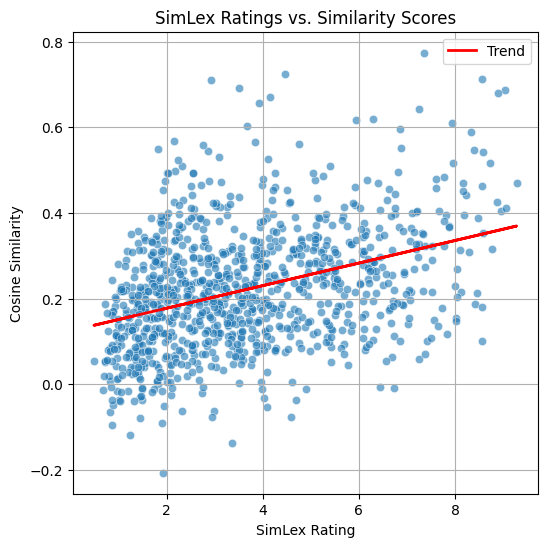

In [447]:
plot_similarities_scatterplot(model_wp, tokenizer_wp, simlex_pairs)

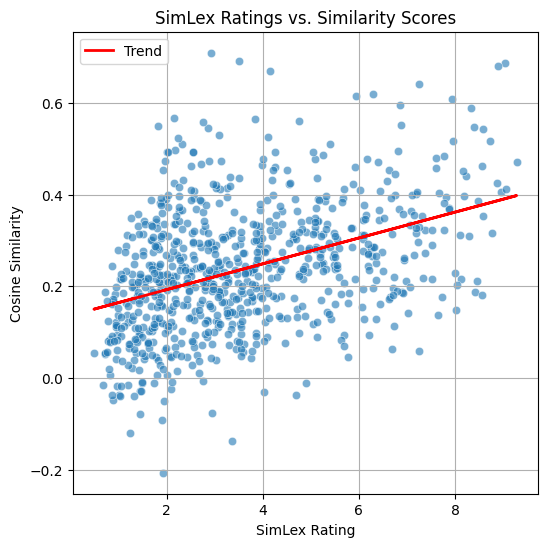

In [499]:
plot_similarities_scatterplot(model_wp, tokenizer_wp, wp_pairs[0])

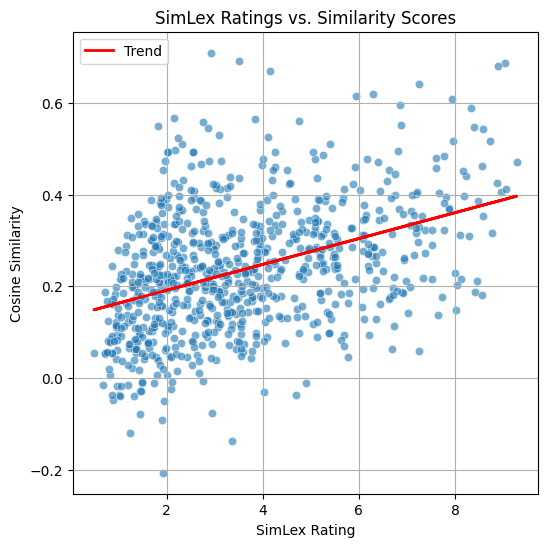

In [500]:
plot_similarities_scatterplot(model_wp, tokenizer_wp, wp_pairs[1])

In [449]:
plot_similarities_scatterplot_save(model_wp, tokenizer_wp, simlex_pairs, output_file='scatterplot_wp.png')

In [515]:
# to lateX

df = get_sorted_similarities_for_word_pairs_df(model_bpe, tokenizer_bpe, simlex_pairs, reverse=False)

# df['SimLex normalized'] = df['SimLex normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))
# df['Cosine normalized'] = df['Cosine normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))


subset_df_top = df.head(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]
subset_df_bottom = df.tail(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]

subset_df = pd.concat([subset_df_top, subset_df_bottom])

# Convert the subset to a LaTeX table
latex_table = subset_df.to_latex(index=False)

print(latex_table)

\begin{tabular}{llrr}
\toprule
Word 1 & Word 2 & SimLex normalized & Cosine normalized \\
\midrule
slecht & verschrikkelijk & 6.590000 & 6.590000 \\
leider & manager & 6.820000 & 6.840000 \\
leraar & instructeur & 7.410000 & 7.440000 \\
slecht & vreselijk & 5.460000 & 5.490000 \\
koesteren & houden & 5.620000 & 5.590000 \\
desorganiseren & organiseren & 1.870000 & 9.220000 \\
zelfvertrouwen & zelf & 1.220000 & 8.630000 \\
besteden & redden & 0.070000 & 7.670000 \\
meisje & dienstmeisje & 1.030000 & 8.860000 \\
aanmoedigen & ontmoedigen & 0.790000 & 9.000000 \\
\bottomrule
\end{tabular}



#### BPE

In [391]:
print_similarities(model_bpe, tokenizer_bpe, simlex_pairs, reverse=False)

Best matches between simlex and model:

('slecht', 'verschrikkelijk', 6.93, 0.318558931350708)
('leider', 'manager', 7.14, 0.36725011467933655)
('leraar', 'instructeur', 7.67, 0.48734602332115173)
('slecht', 'vreselijk', 5.91, 0.09740924090147018)
('koesteren', 'houden', 6.06, 0.11800254881381989)
('kinderbed', 'wieg', 6.15, 0.15113194286823273)
('gelukkig', 'vrolijk', 6.49, 0.22873196005821228)
('student', 'leerling', 7.77, 0.5135403275489807)
('huis', 'appartement', 6.3, 0.19154810905456543)
('wijsheid', 'intelligentie', 6.42, 0.18948839604854584)


In [392]:
print_similarities(model_bpe, tokenizer_bpe, simlex_pairs, reverse=True)

Worst matches between simlex and model:

('aanmoedigen', 'ontmoedigen', 1.71, 0.7990370392799377)
('meisje', 'dienstmeisje', 1.93, 0.7727886438369751)
('besteden', 'redden', 1.06, 0.5332357287406921)
('zelfvertrouwen', 'zelf', 2.1, 0.7268949151039124)
('desorganiseren', 'organiseren', 2.68, 0.8448622226715088)
('afwezigheid', 'aanwezigheid', 2.54, 0.7985525131225586)
('lenen', 'verkopen', 1.28, 0.4683755040168762)
('maaltijd', 'staart', 0.49, 0.2856150269508362)
('container', 'muis', 0.94, 0.3501855134963989)
('vinger', 'handpalm', 1.15, 0.38050419092178345)


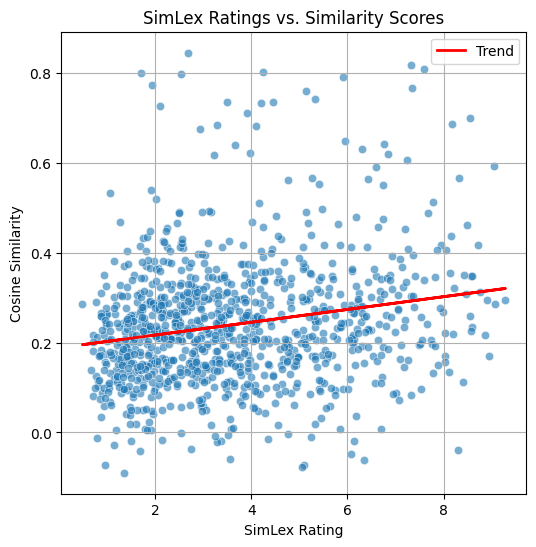

In [448]:
plot_similarities_scatterplot(model_bpe, tokenizer_bpe, simlex_pairs) # new

In [450]:
plot_similarities_scatterplot_save(model_bpe, tokenizer_bpe, simlex_pairs, output_file='scatterplot_bpe.png')

In [517]:
# to lateX

df = get_sorted_similarities_for_word_pairs_df(model_morf, tokenizer_morf, simlex_pairs, reverse=False)

df['SimLex normalized'] = df['SimLex normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))
df['Cosine normalized'] = df['Cosine normalized'].apply(lambda x: f'{x:.2f}'.rstrip('0').rstrip('.'))


subset_df_top = df.head(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]
subset_df_bottom = df.tail(5)[['Word 1', 'Word 2', 'SimLex normalized', 'Cosine normalized']]

subset_df = pd.concat([subset_df_top, subset_df_bottom])

# Convert the subset to a LaTeX table
latex_table = subset_df.to_latex(index=False)

print(latex_table)

\begin{tabular}{llll}
\toprule
Word 1 & Word 2 & SimLex normalized & Cosine normalized \\
\midrule
stijl & mode & 5.64 & 5.65 \\
bruidegom & bruid & 5.5 & 5.5 \\
maat & omvang & 5 & 5 \\
dood & tragedie & 4.92 & 4.91 \\
muziek & melodie & 4.73 & 4.72 \\
besteden & redden & 0.07 & 7.36 \\
verliezen & houden & 0.1 & 7.66 \\
badkamer & slaapkamer & 1.14 & 8.81 \\
lenen & verkopen & 0.31 & 8.07 \\
aanmoedigen & ontmoedigen & 0.79 & 9.01 \\
\bottomrule
\end{tabular}



#### MORF

In [586]:
print_similarities(model_morf, tokenizer_morf, simlex_pairs, reverse=False)

Best matches between simlex and model:

('auto', 'rijtuig', 6.3, 0.17739984393119812, 0.0001889669232898461)
('helper', 'huishulp', 5.37, -0.029744397848844528, 0.00042775447997783766)
('ongeval', 'ramp', 5.48, -0.010726138949394226, 0.003140847252474932)
('ouder', 'volwassene', 5.33, -0.030951734632253647, 0.003413021572762076)
('avondeten', 'maaltijd', 6.14, 0.15072926878929138, 0.004253523283534566)
('ziekte', 'infectie', 6.07, 0.1356552541255951, 0.004494293729464194)
('nier', 'orgaan', 6.35, 0.17840278148651123, 0.005243053701188827)
('kiezen', 'stemmen op', 5.45, -0.02160658687353134, 0.005247737881210135)
('vrouw', 'man', 5.08, -0.10476893186569214, 0.005717799266179435)
('bier', 'drank', 5.67, 0.05068148300051689, 0.006451852611369602)


In [588]:
print_similarities(model_morf, tokenizer_morf, simlex_pairs, reverse=True)

Worst matches between simlex and model:

('aanmoedigen', 'ontmoedigen', 1.71, 0.8011406660079956, 0.8216814441151089)
('lenen', 'verkopen', 1.28, 0.6134177446365356, 0.7755977612071567)
('badkamer', 'slaapkamer', 2.03, 0.7628785967826843, 0.7669948539468977)
('verliezen', 'houden', 1.09, 0.5324879288673401, 0.75624396443367)
('besteden', 'redden', 1.06, 0.47199344635009766, 0.7293300565083821)
('accepteren', 'bezorgen', 1.41, 0.521480917930603, 0.7151849034097459)
('krijgen', 'kopen', 2.12, 0.6442469954490662, 0.6976790532800886)
('zelfvertrouwen', 'zelf', 2.1, 0.636062741279602, 0.6958091484175788)
('pleiten', 'bedelen', 1.73, 0.5287232398986816, 0.6832505088382297)
('vernietigen', 'bouwen', 1.46, 0.4636501967906952, 0.6807139872842365)


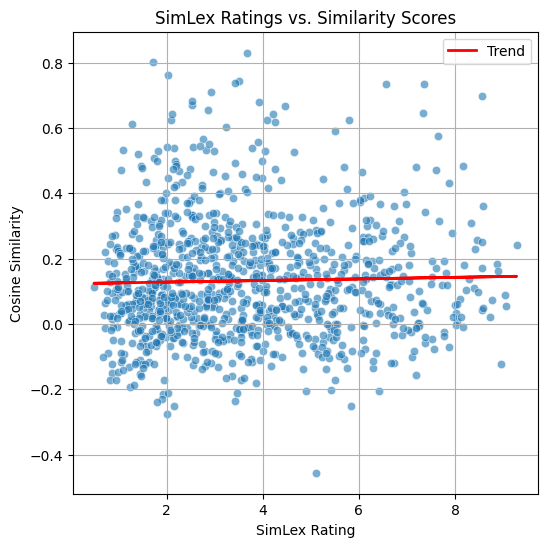

In [451]:
plot_similarities_scatterplot(model_morf, tokenizer_morf, simlex_pairs) # new

In [452]:
plot_similarities_scatterplot_save(model_morf, tokenizer_morf, simlex_pairs, output_file='scatterplot_morf.png')

#### Specifieke woorden

In [133]:
word_pairs = [('ontmoedigen', 'aanmoedigen', 3, 'x')] #, ('meisje', 'dienstmeisje', 3, 'x'), ('organiseren', 'desorganiseren', 3, 'x')]
word_pairs = [('meisje', 'dienstmeisje', 3, 'x')]
word_pairs = [('noord', 'zuid', 3, 'x')]
word_pairs = [('desorganiseren', 'organiseren', 3, 'x')]

In [134]:
get_similarities_for_word_pairs(model_morf, tokenizer_morf, word_pairs, layer='embedding')

[('desorganiseren', 'organiseren', 3.0, 0.15493817627429962)]

In [135]:
for i in range(8):
    print(get_similarities_for_word_pairs(model_wp, tokenizer_wp, word_pairs, layer=i))

[('desorganiseren', 'organiseren', 3.0, 0.38729920983314514)]
[('desorganiseren', 'organiseren', 3.0, 0.6540512442588806)]
[('desorganiseren', 'organiseren', 3.0, 0.6738194227218628)]
[('desorganiseren', 'organiseren', 3.0, 0.6663439273834229)]
[('desorganiseren', 'organiseren', 3.0, 0.5950630307197571)]
[('desorganiseren', 'organiseren', 3.0, 0.39763131737709045)]
[('desorganiseren', 'organiseren', 3.0, 0.4253077208995819)]
[('desorganiseren', 'organiseren', 3.0, 0.275326669216156)]


#### Specifieke woorden

In [141]:
words = ['ontmoedigen', 'aanmoedigen', 'meisje', 'dienstmeisje', 'organiseren', 'desorganiseren', 'vertrouwen', 'zelfvertrouwen', 'onderkant', 'zijkant', 'slaapkamer', 'badkamer']

In [142]:
tokenizer_segmentations(words, tokenizer_wp)

{'ontmoedigen': ['ontmo', 'ed', 'igen'],
 'aanmoedigen': ['aanmoedigen'],
 'meisje': ['meisje'],
 'dienstmeisje': ['dienst', 'meisje'],
 'organiseren': ['organiseren'],
 'desorganiseren': ['des', 'organis', 'eren'],
 'vertrouwen': ['vertrouwen'],
 'zelfvertrouwen': ['zelfvertrouwen'],
 'onderkant': ['onderkant'],
 'zijkant': ['zijkant'],
 'slaapkamer': ['slaapkamer'],
 'badkamer': ['badkamer']}

In [143]:
tokenizer_segmentations(words, tokenizer_bpe)

{'ontmoedigen': ['ont', 'moed', 'igen'],
 'aanmoedigen': ['aan', 'moed', 'igen'],
 'meisje': ['meisje'],
 'dienstmeisje': ['dienst', 'meisje'],
 'organiseren': ['organis', 'eren'],
 'desorganiseren': ['des', 'organis', 'eren'],
 'vertrouwen': ['vertrouwen'],
 'zelfvertrouwen': ['zelf', 'vertrouwen'],
 'onderkant': ['onder', 'kant'],
 'zijkant': ['z', 'ijk', 'ant'],
 'slaapkamer': ['slaapkamer'],
 'badkamer': ['badkamer']}

In [144]:
tokenizer_segmentations(words, tokenizer_morf)

{'ontmoedigen': ['ont', 'moed', 'ig', 'en'],
 'aanmoedigen': ['aan', 'moed', 'ig', 'en'],
 'meisje': ['meisje'],
 'dienstmeisje': ['dien', 'st', 'meisje'],
 'organiseren': ['organiseren'],
 'desorganiseren': ['des', 'organ', 'iseren'],
 'vertrouwen': ['vertrouwen'],
 'zelfvertrouwen': ['zelf', 'vertrouwen'],
 'onderkant': ['onder', 'kant'],
 'zijkant': ['zij', 'kant'],
 'slaapkamer': ['slaap', 'kamer'],
 'badkamer': ['bad', 'kamer']}

### test: what is the effect of adding special tokens?

In [345]:
def get_word_embedding(model, tokenizer, word):

    inputs = tokenizer(word, return_tensors='pt')
    input_ids = inputs['input_ids']

    print(input_ids)

    with torch.no_grad():
        embeddings = model.get_input_embeddings()(input_ids)

    word_embedding = embeddings.squeeze(0).mean(dim=0)
    
    return word_embedding



def get_word_embedding_no_special_tokens(model, tokenizer, word):

    inputs = tokenizer(word, return_tensors='pt')
    input_ids = inputs['input_ids']


    if input_ids.shape[1] > 2:  
        input_ids = input_ids[:, 1:-1]
    
    print(input_ids)


    with torch.no_grad():
        embeddings = model.get_input_embeddings()(input_ids)

    word_embedding = embeddings.squeeze(0).mean(dim=0)
    
    return word_embedding


In [347]:
word = 'achteruitkijkspiegel'
# tokenizer = tokenizer_bpe
# tokenizer = tokenizer_morf
tokenizer = tokenizer_wp

# print(tokenizer(word, return_tensors='pt')['input_ids'][0[2])

# get_word_embedding(model_bpe, tokenizer_bpe, word) == get_word_embedding_no_special_tokens(model_bpe, tokenizer_bpe, word)


get_word_embedding(model_robbert, tokenizer_robbert, word) == get_word_embedding_no_special_tokens(model_robbert, tokenizer_robbert, word)


tensor([[    0, 13478, 24829, 13959,     3]])
tensor([[13478, 24829, 13959]])


tensor([False, False, False,  ..., False, False, False])

## Model evaluation 3: POS tagging

### NOTE: This evaluation is performed in another notebook

## Model evaluation 4: Sentiment analysis

### NOTE: This evaluation is performed in another notebook